Chargement du dataset Mall_Customers...
Aperçu des données Mall_Customers:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
Dimensions du dataset: (200, 5)
Colonnes: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual In

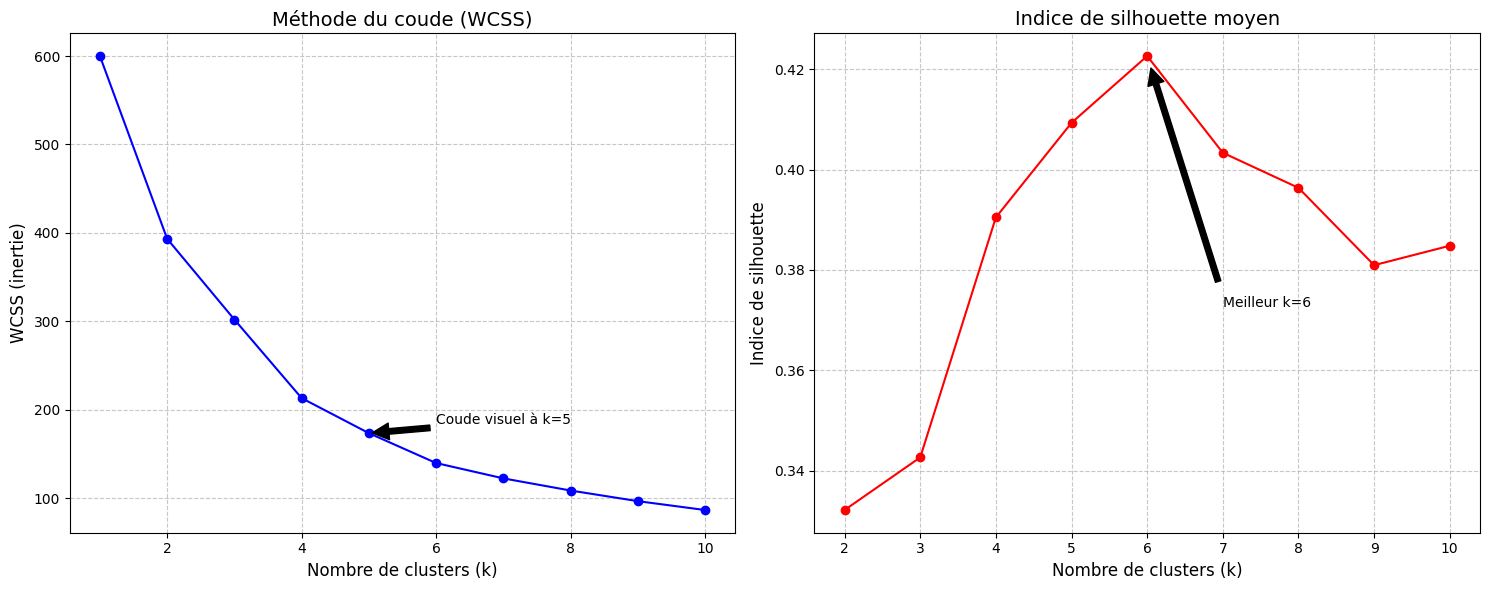


Résultats de l'analyse:
K | WCSS (inertie) | Silhouette
----------------------------------------
1 | 600.00 | 0.0000
2 | 393.25 | 0.3322
3 | 301.91 | 0.3427
4 | 213.01 | 0.3905
5 | 173.37 | 0.4093
6 | 139.57 | 0.4226
7 | 122.21 | 0.4033
8 | 108.47 | 0.3964
9 | 96.45 | 0.3810
10 | 86.41 | 0.3848

Méthode du coude: K optimal = 5
Méthode de la silhouette: K optimal = 6
Les deux méthodes suggèrent des nombres différents de clusters:
- Méthode du coude: K=5
- Méthode de la silhouette: K=6
Comme la méthode du coude montre une inflexion claire à K=5, nous retenons cette valeur.

Nombre optimal de clusters retenu: K=5

=== Tests avec K = 6 ===

Notre implémentation de K-means:
Inertie: 139.7143
Score de silhouette: 0.4241

Implémentation scikit-learn de K-means:
Inertie: 139.5673
Score de silhouette: 0.4226


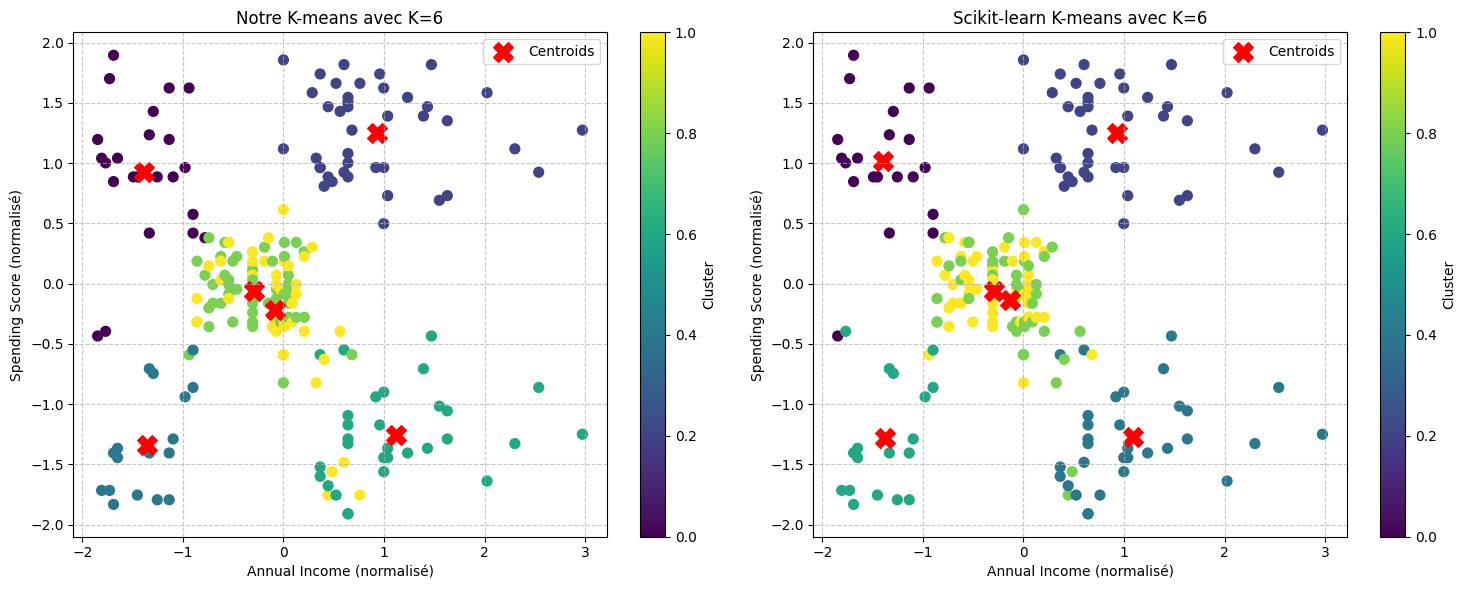

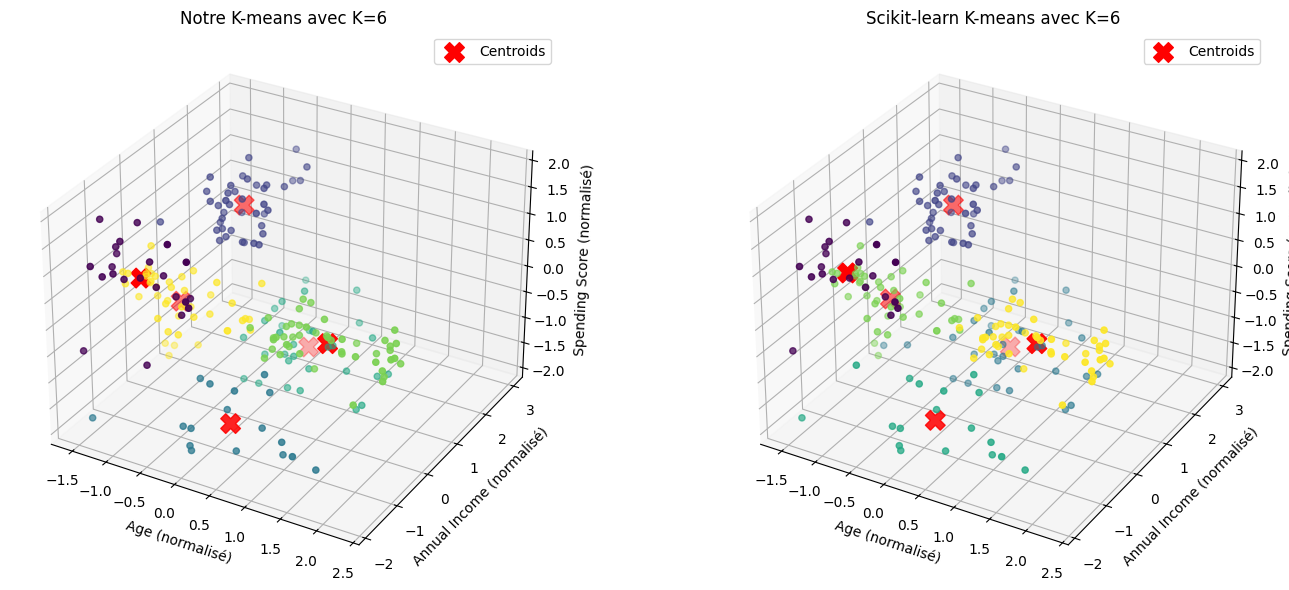


Statistiques par cluster:
Notre implémentation:
Cluster 0 (taille: 23):
             Age  Annual Income (k$)  Spending Score (1-100)
count  23.000000           23.000000               23.000000
mean   27.583819           26.739130               74.043478
std     6.743811            8.914836               15.122164
min    18.000000           15.000000               39.000000
25%    22.000000           18.500000               68.500000
50%    25.000000           28.000000               75.000000
75%    32.000000           33.500000               81.500000
max    38.809278           42.000000               99.000000
------------------------------------------------------------
Cluster 1 (taille: 41):
             Age  Annual Income (k$)  Spending Score (1-100)
count  41.000000           41.000000               41.000000
mean   32.487805           85.329394               82.439024
std     4.019465           16.793181                9.473776
min    22.000000           61.752577             

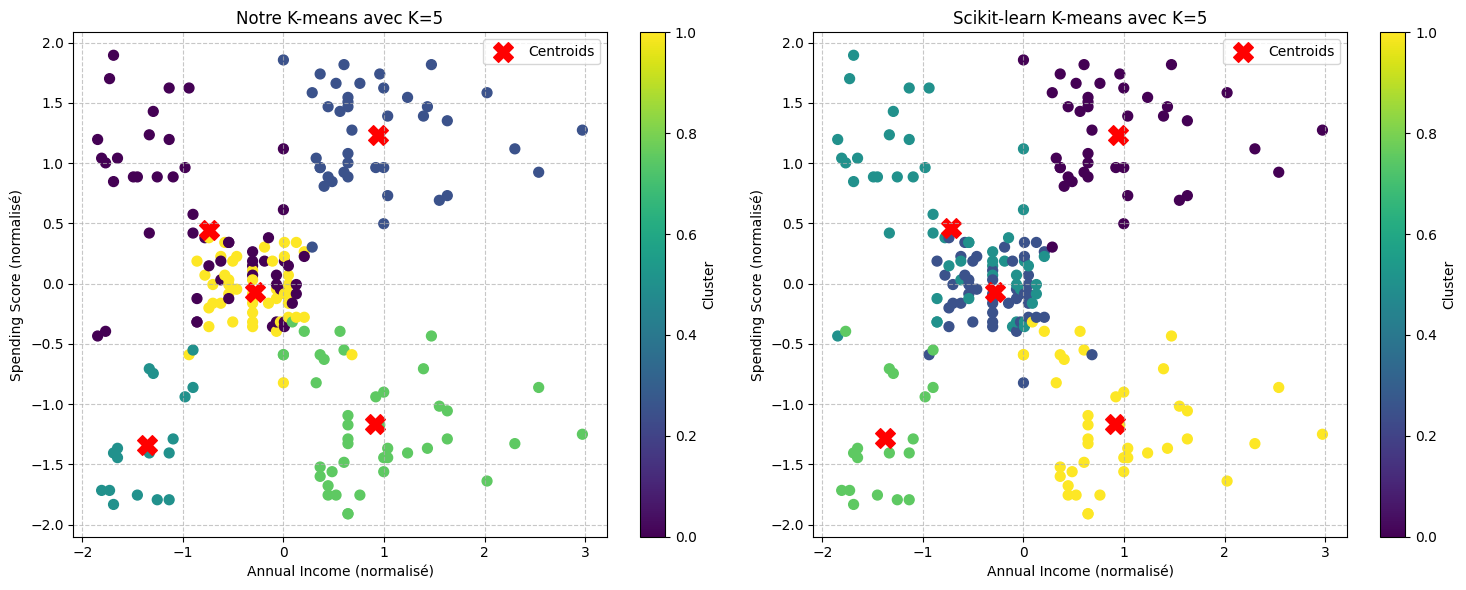

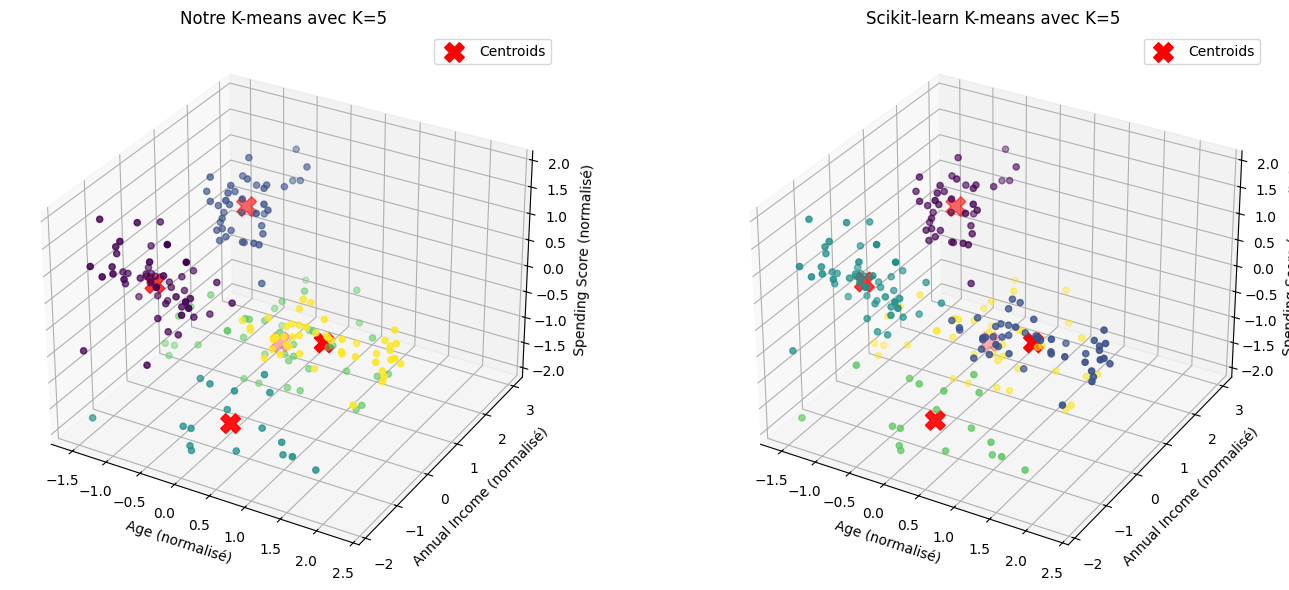


Statistiques par cluster:
Notre implémentation:
Cluster 0 (taille: 53):
             Age  Annual Income (k$)  Spending Score (1-100)
count  53.000000           53.000000               53.000000
mean   25.781657           42.990663               61.566038
std     6.219860           16.683314               15.989792
min    18.000000           15.000000               39.000000
25%    21.000000           29.000000               50.000000
50%    24.000000           43.000000               57.000000
75%    31.000000           60.000000               73.000000
max    38.809278           67.000000               99.000000
------------------------------------------------------------
Cluster 1 (taille: 41):
             Age  Annual Income (k$)  Spending Score (1-100)
count  41.000000           41.000000               41.000000
mean   32.926829           85.506160               81.926829
std     3.823547           16.575538               10.203897
min    27.000000           61.752577             

In [5]:
# mall_customers_clustering.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SKLearnKMeans
from sklearn.impute import SimpleImputer


class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        """
        Initialize KMeans algorithm.

        Parameters:
        -----------
        n_clusters : int, default=3
            Number of clusters to form.
        max_iter : int, default=100
            Maximum number of iterations of the algorithm.
        tol : float, default=1e-4
            Relative tolerance with regards to inertia to declare convergence.
        random_state : int, default=None
            Seed for random number generator.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        """
        Compute k-means clustering.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training instances to cluster.

        Returns:
        --------
        self : object
            Fitted estimator.
        """
        # Set random state for reproducibility
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Get dimensions of data
        n_samples, n_features = X.shape

        # Initialize centroids by randomly selecting from data points
        # Following Algorithm 1 in the PDF, line 1
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        # Initialize labels
        old_labels = np.zeros(n_samples)

        # Iterative algorithm (lines 2-8 in Algorithm 1)
        for iteration in range(self.max_iter):
            # Calculate distances between all points and all centroids
            distances = np.sqrt(((X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :]) ** 2).sum(axis=2))

            # Assign each point to the nearest centroid (line 4)
            self.labels_ = np.argmin(distances, axis=1)

            # Check for convergence (if labels haven't changed)
            if np.all(old_labels == self.labels_):
                break

            old_labels = self.labels_.copy()

            # Update centroids based on new cluster assignments (line 6)
            for k in range(self.n_clusters):
                if np.sum(self.labels_ == k) > 0:  # Avoid empty clusters
                    self.centroids[k] = np.mean(X[self.labels_ == k], axis=0)

        # Calculate inertia (sum of squared distances to closest centroid)
        # This corresponds to J in equation (1) of the PDF
        self.inertia_ = 0
        for k in range(self.n_clusters):
            cluster_points = X[self.labels_ == k]
            if len(cluster_points) > 0:
                self.inertia_ += np.sum((cluster_points - self.centroids[k]) ** 2)

        return self

    def predict(self, X):
        """
        Predict the closest cluster each sample in X belongs to.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            New data to predict.

        Returns:
        --------
        labels : array of shape (n_samples,)
            Index of the cluster each sample belongs to.
        """
        # Calculate distances between all points and all centroids
        distances = np.sqrt(((X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :]) ** 2).sum(axis=2))

        # Return cluster index for each point
        return np.argmin(distances, axis=1)

# 1. Charger le dataset Mall_Customers
print("Chargement du dataset Mall_Customers...")
try:
    # Si le fichier existe localement
    df = pd.read_csv("Mall_Customers.csv")
except:
    # Télécharger depuis GitHub
    print("Téléchargement depuis GitHub...")
    import urllib.request
    url = "https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv"
    urllib.request.urlretrieve(url, "Mall_Customers.csv")
    df = pd.read_csv("Mall_Customers.csv")

# Afficher les informations sur le dataset
print("Aperçu des données Mall_Customers:")
print(df.head())
print(f"Dimensions du dataset: {df.shape}")
print(f"Colonnes: {df.columns.tolist()}")
print(df.info())
print(df.describe())

# 2. Introduire artificiellement des valeurs manquantes comme demandé dans le PDF
print("\nIntroduction artificielle de valeurs manquantes...")
df.loc[5:10, "Age"] = np.nan
df.loc[15:20, "Annual Income (k$)"] = np.nan

print("Nombre de valeurs manquantes après modification:")
print(df.isnull().sum())

# 3. Imputer les valeurs manquantes avec la moyenne
print("\nImputation des valeurs manquantes avec la moyenne...")
imputer = SimpleImputer(strategy="mean")

# Sélectionner les colonnes numériques pour l'imputation
df[["Age", "Annual Income (k$)"]] = imputer.fit_transform(df[["Age", "Annual Income (k$)"]])

print("Nombre de valeurs manquantes après imputation:")
print(df.isnull().sum())

# 4. Sélectionner les variables numériques pour le clustering
X = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].values

# 5. Normaliser les données
print("\nNormalisation des données...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Détermination du nombre de clusters par la méthode du coude et de la silhouette
print("\n=== Détermination du nombre optimal de clusters ===")
wcss = []  # Within-Cluster Sum of Squares (WCSS) ou inertie
silhouette_scores = []  # Scores de silhouette pour chaque K
k_range = range(1, 11)  # Tester de 1 à 10 clusters

# Calculer l'inertie et le score de silhouette pour différentes valeurs de K
for k in k_range:
    # Utiliser scikit-learn pour calculer les métriques
    kmeans = SKLearnKMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

    # Calculer le score de silhouette (pas disponible pour k=1)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    else:
        silhouette_scores.append(0)  # Silhouette non définie pour k=1

# Tracer les deux métriques en fonction de K
plt.figure(figsize=(15, 6))

# Méthode du coude
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-')
plt.title('Méthode du coude (WCSS)', fontsize=14)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('WCSS (inertie)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

coude_k = 5  # inspection visuelle du graphique, à ajuster selon le graphique réel

plt.annotate(f'Coude visuel à k={coude_k}',
             xy=(coude_k, wcss[coude_k-1]),
             xytext=(coude_k+1, wcss[coude_k-1]+10),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Indice de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'ro-')  # Commencer à k=2
plt.title('Indice de silhouette moyen', fontsize=14)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Indice de silhouette', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Identifier le k avec le meilleur score de silhouette
best_silhouette_k = np.argmax(silhouette_scores[1:]) + 2  # +2 car on commence à k=2

plt.annotate(f'Meilleur k={best_silhouette_k}',
             xy=(best_silhouette_k, silhouette_scores[best_silhouette_k-1]),
             xytext=(best_silhouette_k+1, silhouette_scores[best_silhouette_k-1]-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.savefig('mall_customers_elbow_silhouette_method.png')
plt.show()

# Résultats numériques et analyse
print("\nRésultats de l'analyse:")
print("K | WCSS (inertie) | Silhouette")
print("-" * 40)
for k in k_range:
    print(f"{k} | {wcss[k-1]:.2f} | {silhouette_scores[k-1]:.4f}")

print(f"\nMéthode du coude: K optimal = {coude_k}")
print(f"Méthode de la silhouette: K optimal = {best_silhouette_k}")

# Analyse des résultats
if coude_k == best_silhouette_k:
    print(f"Les deux méthodes suggèrent le même nombre optimal de clusters: K={coude_k}")
    optimal_k = coude_k
else:
    print(f"Les deux méthodes suggèrent des nombres différents de clusters:")
    print(f"- Méthode du coude: K={coude_k}")
    print(f"- Méthode de la silhouette: K={best_silhouette_k}")

    # Pour Mall_Customers, on peut faire un choix basé sur la segmentation client
    if silhouette_scores[best_silhouette_k-1] > 0.5:  # Une silhouette > 0.5 est généralement un bon signe
        print(f"Comme le score de silhouette est bon ({silhouette_scores[best_silhouette_k-1]:.4f}), nous retenons K={best_silhouette_k} basé sur la méthode de la silhouette.")
        optimal_k = best_silhouette_k
    else:
        print(f"Comme la méthode du coude montre une inflexion claire à K={coude_k}, nous retenons cette valeur.")
        optimal_k = coude_k

print(f"\nNombre optimal de clusters retenu: K={optimal_k}")

# Pour l'analyse, nous allons tester avec les K optimaux trouvés par les deux méthodes
k_values = [best_silhouette_k, coude_k] if best_silhouette_k != coude_k else [best_silhouette_k, best_silhouette_k+1]

# 6. Entrainer les modèles et évaluer les performances pour chaque K
results = []

for k in k_values:
    print(f"\n=== Tests avec K = {k} ===")

    # A. Notre implémentation de K-means
    print("\nNotre implémentation de K-means:")
    custom_model = KMeans(n_clusters=k, random_state=42, max_iter=100)
    custom_model.fit(X_scaled)
    custom_pred = custom_model.labels_

    # Calculer les métriques d'évaluation
    custom_inertia = custom_model.inertia_

    # Calculer le score de silhouette
    custom_silhouette = silhouette_score(X_scaled, custom_pred) if k > 1 else 0

    print(f"Inertie: {custom_inertia:.4f}")
    print(f"Score de silhouette: {custom_silhouette:.4f}")

    # B. Implémentation scikit-learn de K-means
    print("\nImplémentation scikit-learn de K-means:")
    sklearn_model = SKLearnKMeans(n_clusters=k, random_state=42, n_init=10)
    sklearn_model.fit(X_scaled)
    sklearn_pred = sklearn_model.labels_

    # Calculer les métriques d'évaluation
    sklearn_inertia = sklearn_model.inertia_

    # Calculer le score de silhouette
    sklearn_silhouette = silhouette_score(X_scaled, sklearn_pred) if k > 1 else 0

    print(f"Inertie: {sklearn_inertia:.4f}")
    print(f"Score de silhouette: {sklearn_silhouette:.4f}")

    # Stocker les résultats
    results.append({
        'K': k,
        'Impl': 'Notre K-means',
        'Inertia': custom_inertia,
        'Silhouette': custom_silhouette
    })
    results.append({
        'K': k,
        'Impl': 'Scikit-learn K-means',
        'Inertia': sklearn_inertia,
        'Silhouette': sklearn_silhouette
    })

    # 7. Visualiser les clusters et les centroïdes pour les deux implémentations
    # Pour le Mall_Customers, utilisons Annual Income vs Spending Score pour la visualisation 2D
    plt.figure(figsize=(15, 6))

    # Notre implémentation
    plt.subplot(1, 2, 1)
    plt.scatter(X_scaled[:, 1], X_scaled[:, 2], c=custom_pred, cmap='viridis', s=50)
    plt.scatter(custom_model.centroids[:, 1], custom_model.centroids[:, 2],
                c='red', marker='X', s=200, label='Centroids')
    plt.title(f'Notre K-means avec K={k}')
    plt.xlabel("Annual Income (normalisé)")
    plt.ylabel("Spending Score (normalisé)")
    plt.colorbar(label='Cluster')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Scikit-learn implémentation
    plt.subplot(1, 2, 2)
    plt.scatter(X_scaled[:, 1], X_scaled[:, 2], c=sklearn_pred, cmap='viridis', s=50)
    plt.scatter(sklearn_model.cluster_centers_[:, 1], sklearn_model.cluster_centers_[:, 2],
                c='red', marker='X', s=200, label='Centroids')
    plt.title(f'Scikit-learn K-means avec K={k}')
    plt.xlabel("Annual Income (normalisé)")
    plt.ylabel("Spending Score (normalisé)")
    plt.colorbar(label='Cluster')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'mall_customers_kmeans_comparison_k{k}.png')
    plt.show()

    # 8. Visualisation 3D (Age, Annual Income, Spending Score)
    fig = plt.figure(figsize=(15, 6))

    # Notre implémentation
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=custom_pred, cmap='viridis')
    ax1.scatter(custom_model.centroids[:, 0], custom_model.centroids[:, 1], custom_model.centroids[:, 2],
                c='red', marker='X', s=200, label='Centroids')
    ax1.set_title(f'Notre K-means avec K={k}')
    ax1.set_xlabel('Age (normalisé)')
    ax1.set_ylabel('Annual Income (normalisé)')
    ax1.set_zlabel('Spending Score (normalisé)')
    ax1.legend()

    # Scikit-learn
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=sklearn_pred, cmap='viridis')
    ax2.scatter(sklearn_model.cluster_centers_[:, 0], sklearn_model.cluster_centers_[:, 1],
                sklearn_model.cluster_centers_[:, 2], c='red', marker='X', s=200, label='Centroids')
    ax2.set_title(f'Scikit-learn K-means avec K={k}')
    ax2.set_xlabel('Age (normalisé)')
    ax2.set_ylabel('Annual Income (normalisé)')
    ax2.set_zlabel('Spending Score (normalisé)')
    ax2.legend()

    plt.tight_layout()
    plt.savefig(f'mall_customers_3d_clusters_k{k}.png')
    plt.show()

    # Afficher les statistiques de chaque cluster pour l'interprétation
    print("\nStatistiques par cluster:")

    # Notre implémentation
    print("Notre implémentation:")
    custom_clusters_df = pd.DataFrame(data=X, columns=["Age", "Annual Income (k$)", "Spending Score (1-100)"])
    custom_clusters_df['Cluster'] = custom_pred

    for i in range(k):
        cluster_data = custom_clusters_df[custom_clusters_df['Cluster'] == i]
        print(f"Cluster {i} (taille: {len(cluster_data)}):")
        print(cluster_data.describe()[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
        print("-" * 60)

    # Scikit-learn
    print("\nImplémentation scikit-learn:")
    sklearn_clusters_df = pd.DataFrame(data=X, columns=["Age", "Annual Income (k$)", "Spending Score (1-100)"])
    sklearn_clusters_df['Cluster'] = sklearn_pred

    for i in range(k):
        cluster_data = sklearn_clusters_df[sklearn_clusters_df['Cluster'] == i]
        print(f"Cluster {i} (taille: {len(cluster_data)}):")
        print(cluster_data.describe()[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
        print("-" * 60)

# 9. Résumé des résultats
results_df = pd.DataFrame(results)
print("\nRésumé des résultats:")
print(results_df)

# 10. Comparer les performances des deux implémentations
print("\nAnalyse comparative:")

# Calculer les différences de performance
for k in k_values:
    custom_results = results_df[(results_df['K'] == k) & (results_df['Impl'] == 'Notre K-means')]
    sklearn_results = results_df[(results_df['K'] == k) & (results_df['Impl'] == 'Scikit-learn K-means')]

    inertia_diff = custom_results['Inertia'].values[0] - sklearn_results['Inertia'].values[0]
    silhouette_diff = custom_results['Silhouette'].values[0] - sklearn_results['Silhouette'].values[0]

    print(f"Pour K = {k}:")
    print(f"  Différence d'Inertie: {inertia_diff:.4f} (négatif = notre implémentation est meilleure)")
    print(f"  Différence de Silhouette: {silhouette_diff:.4f} (positif = notre implémentation est meilleure)")

# 11. Conclusion globale
print("\nConclusion:")
best_k_silhouette = results_df.groupby('K')['Silhouette'].mean().idxmax()
best_k_inertia = results_df.groupby('K')['Inertia'].mean().idxmin()

print(f"Meilleur K selon Silhouette (moyenne des deux implémentations): K = {best_k_silhouette}")
print(f"Meilleur K selon Inertie (moyenne des deux implémentations): K = {best_k_inertia}")

# Vérifier si les métriques concordent
if best_k_silhouette == best_k_inertia:
    print(f"Les deux métriques suggèrent que K = {best_k_silhouette} est le meilleur choix pour ce dataset.")
else:
    print("Les métriques ne concordent pas sur le meilleur K.")
    print(f"L'analyse des segments de clientèle est plus subjective pour ce dataset sans vérité terrain.")
    print(f"Basé sur la métrique de silhouette qui mesure la cohésion et la séparation des clusters,")
    print(f"K = {best_k_silhouette} semble être un bon choix.")
